### Core

In [1]:
# headers
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
from torchmetrics import Accuracy
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Functions
def tensorprint(tensor):
    print("Shape: " , tensor.shape, " , Dimension: ", tensor.ndim , " \nDtype: ", tensor.dtype, " , Device: ", tensor.device)
    print("Max: ", tensor.amax(),f'[{tensor.argmax()}]', " , Min: ", tensor.amin(),f'[{tensor.argmin()}]')
    print(tensor ,'\n')

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

def torch_rng():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

### Classification fundamentals

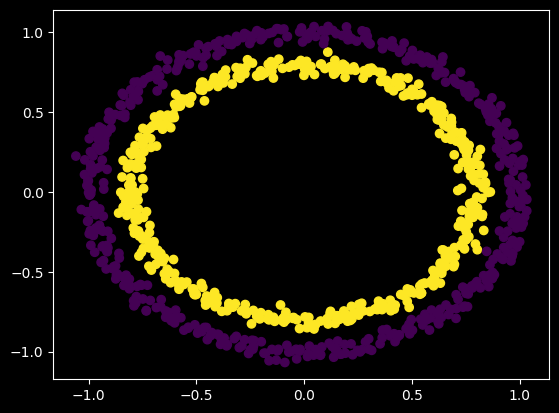

In [3]:
# Create a dataset 
X,y = make_circles(n_samples=1000, noise = 0.03, random_state=42)
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label":y})
plt.scatter(x =X[:,0],y=X[:,1], c =y)

In [4]:
# Turn to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
tensorprint(X)
tensorprint(y)

Shape:  torch.Size([1000, 2])  , Dimension:  2  
Dtype:  torch.float32  , Device:  cpu
Max:  tensor(1.0360) [1089]  , Min:  tensor(-1.0678) [69]
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]]) 

Shape:  torch.Size([1000])  , Dimension:  1  
Dtype:  torch.float32  , Device:  cpu
Max:  tensor(1.) [0]  , Min:  tensor(0.) [4]
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.

In [5]:
# Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, # 80% train
                                                    random_state=42)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
tensorprint(X_train)
tensorprint(X_test)


Shape:  torch.Size([800, 2])  , Dimension:  2  
Dtype:  torch.float32  , Device:  cuda:0
Max:  tensor(1.0360, device='cuda:0') [53]  , Min:  tensor(-1.0678, device='cuda:0') [1443]
tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0') 

Shape:  torch.Size([200, 2])  , Dimension:  2  
Dtype:  torch.float32  , Device:  cuda:0
Max:  tensor(1.0352, device='cuda:0') [201]  , Min:  tensor(-1.0037, device='cuda:0') [144]
tensor([[-3.7519e-01,  6.8266e-01],
        [ 1.5380e-02,  9.6003e-01],
        [-7.0278e-01, -3.1472e-01],
        [-2.8525e-01,  9.6638e-01],
        [ 4.0242e-01, -7.4375e-01],
        [ 6.3228e-01, -5.7111e-01],
        [ 8.5607e-01,  5.4994e-01],
        [ 1.0034e+00,  1.9028e-01],
        [-7.4892e-01, -2.9511e-01],
        [ 5.3780e-02,  9.7388e-01],
        [-4.7020e-01,  7.8749e-01],
        [-2.1686e-01,  7.2418e-01],
     

In [6]:
# Build Model
class CircleModelSeperators(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # 2 features to 8 upscaled || 8 features from previous to output
        self.layer_1 = nn.Linear(in_features = 2, out_features = 8)
        self.layer_2 = nn.Linear(in_features = 8, out_features = 8)
        self.layer_3 = nn.Linear(in_features = 8, out_features = 1)
        
        # non-linear activation functions
        self.relu = nn.ReLU()          

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Build model w/ sequential
model_1s = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=2, out_features=8)
).to(device)

torch_rng()
model_1 = CircleModelSeperators().to(device)
parameters = model_1.state_dict()
with torch.inference_mode():
    untrained_preds_logits = model_1(X_test)
    y_predwt = torch.round(torch.sigmoid(untrained_preds_logits))
accuracy_fn(y_test, y_predwt.squeeze())

50.0

tensor([-0.0840, -0.0997, -0.0317, -0.0992, -0.0404, -0.0840, -0.2143, -0.2210,
        -0.0333, -0.1002, -0.0889, -0.0870, -0.2270, -0.0241, -0.0383, -0.1620,
        -0.1281, -0.0840, -0.0753, -0.0703, -0.1010, -0.1780, -0.0693, -0.0781,
        -0.1773, -0.2145, -0.0144, -0.1210, -0.0404, -0.0188, -0.1663, -0.1691,
        -0.0927, -0.0234, -0.0921, -0.0909, -0.0921, -0.0265, -0.0146, -0.0216,
        -0.0675, -0.0394, -0.1290, -0.0395, -0.0957, -0.1002, -0.0542, -0.1031,
        -0.0884, -0.0661, -0.0978, -0.0975, -0.1421, -0.0330, -0.1843, -0.0142,
        -0.1877, -0.0261, -0.0546, -0.0527, -0.0640, -0.2163, -0.0537, -0.0207,
        -0.0864, -0.0922, -0.1608, -0.1940, -0.1063, -0.1748, -0.1129, -0.1197,
        -0.0470, -0.0384, -0.1827, -0.1040, -0.0156, -0.1953, -0.0893, -0.1550,
        -0.0709, -0.0839, -0.2104, -0.0143, -0.0585, -0.1257, -0.0657, -0.0199,
        -0.0248, -0.1819, -0.0318, -0.0199, -0.0162, -0.0357, -0.0251, -0.0866,
        -0.0917, -0.0447, -0.0716, -0.02

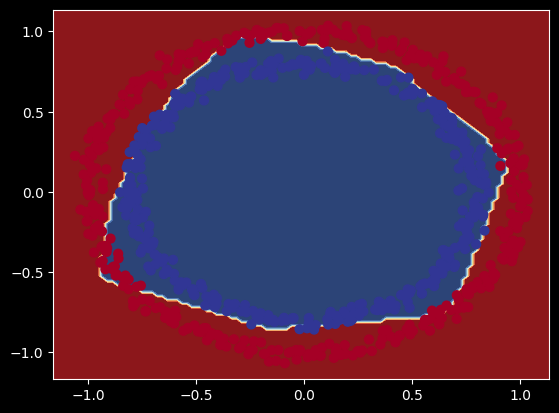

In [7]:
# Training Model
# loss and optimizer
torch_rng()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)
epochs = 1000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()                   # raw logits
    y_pred = torch.round(torch.sigmoid(y_logits))           # raw -> prob -> pred

    loss = loss_fn(y_logits, y_train)                       # (raw_logits, output)                                             
    acc = accuracy_fn(y_train,y_pred)
    optimizer.zero_grad()                                   # set to 0
    loss.backward()                                         # backpropogation
    optimizer.step()                                        # gradiant descent

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        print(test_logits)
        test_pred = torch.round(torch.sigmoid(y_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_train, test_pred)
        if epoch % 100 == 0:
            print(f"Loss: {test_loss:.5f}, Acc: {test_acc:.5f}")
            
plot_decision_boundary(model_1,X_train,y_train)

### Multiclassification Fundamentals

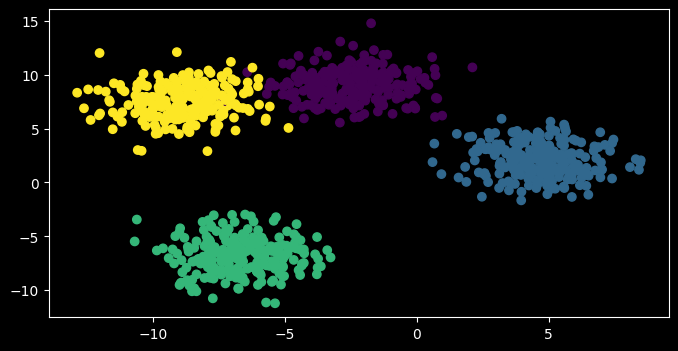

In [8]:
# Dataset
X,y = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42, cluster_std=1.5)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# plot
plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], c = y)

In [9]:
# Build Model
class CircleModelSeperators(nn.Module):
    def __init__(self,input,output,hidden_units = 8) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output)
        )
        

    def forward(self, x):
        return self.linear_layer_stack(x)

torch_rng()
model_2 = CircleModelSeperators(2,4).to(device)
parameters = model_2.state_dict()
with torch.inference_mode():
    untrained_preds_logits = model_2(X_test)
    y_predwt = torch.softmax(untrained_preds_logits, dim=1)
    y_predwt = torch.argmax(y_predwt, dim=1)
    
accuracy_fn(y_test, y_predwt.squeeze())

35.5

In [10]:
# Training Model
torch_rng()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

epoch = 1000

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(1)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        if epoch % 100 == 0:
            print(f"Loss: {test_loss:.5f}, Acc: {test_acc:.5f}")
            

Loss: 1.07554, Acc: 48.00000
Loss: 0.02433, Acc: 99.50000
Loss: 0.01651, Acc: 99.50000
Loss: 0.01440, Acc: 99.50000
Loss: 0.01335, Acc: 99.50000
Loss: 0.01269, Acc: 99.50000
Loss: 0.01218, Acc: 99.50000
Loss: 0.01179, Acc: 99.50000
Loss: 0.01147, Acc: 99.50000
Loss: 0.01120, Acc: 99.50000


tensor(0.9950, device='cuda:0')

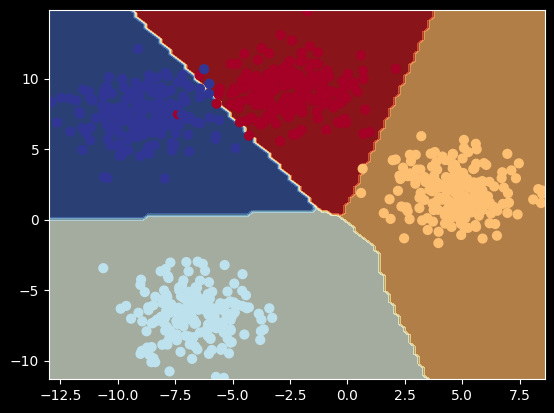

In [11]:
# predictions 
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_test)
    y_pred = torch.softmax(y_logits, dim =1).argmax(dim=1)
    
torchmetric_accuracy = Accuracy(task ='multiclass', num_classes=4).to(device)
plot_decision_boundary(model_2, X_train, y_train)
torchmetric_accuracy(y_pred,y_test)